In [1]:
import numpy as np
import alexas_functions
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.decomposition import PCA
import cartopy.crs as ccrs
#from alexas_functions import extract_region , cc_ev

In [2]:
## lat/lon coordinates of box corners
nn34 = alexas_functions.nn34
ep = alexas_functions.ep
mc = alexas_functions.mc
seas_names = ['summer', 'fall', 'winter', 'spring']
seas_names2 = ['JJA', 'SON', 'DJF', 'MAM']


## show what functions have been imported and are avaialble
alexas_functions.list_my_functions()

## load the files that contain the % of ocean area in each lat/lon grid box at the models' resolution
can_percents = np.loadtxt('C:\\Users\\alexa\\Documents\\RESEARCH\\Alexa_Zabaske\\Python_Notebooks\\datafiles\\CanESM2_OceanPercents.txt')
mpi_percents = np.loadtxt('C:\\Users\\alexa\\Documents\\RESEARCH\\Alexa_Zabaske\\Python_Notebooks\\datafiles\\MPI-ESM_OceanPercents.txt')

## create an array that can be applied to the model data to mask out grid points that are not 100% ocean
## these masks are applied to the 'ts' variable, to mask out any land grid boxes.
sea100_can= alexas_functions.get_landsea_mask(can_percents, mtype='sea')
sea100_mpi = alexas_functions.get_landsea_mask(mpi_percents, mtype='sea')
season_nums = np.array([8,11,2,5]) #JJA, SON, DJF, MMA

the available functions are: 
list_my_functions
test_function
get_filename
get_CMIP_name_list
set_new_time_variable
get_landsea_mask
extract_region
mask_out_regions
reshape
get_PC_components
cc_ev
dump_into_pickle
open_pickle_data
uniform_coords
zonal_avg
Fourier_Analysis
search_box
calc_hits_num
:end of list.


C:\Users\alexa\Documents\RESEARCH\DATA\can_ensm\pr\pr_Amon_CanESM2_historical-r1_r1i1p1_195001-202012.nc
 
lat increment:  2
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  4
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  6
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  8
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  10
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  12
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  14
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  16
lon increments:  10,14,18,22,26,30,34,38,42,46,50,...done.
C:\Users\alexa\Documents\RESEARCH\DATA\can_ensm\pr\pr_Amon_CanESM2_historical-r1_r2i1p1_195001-202012.nc
 
lat increment:  2
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  4
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat increment:  6
lon increments:  10,14,18,22,26,30,34,38,42,46,50, 
lat i

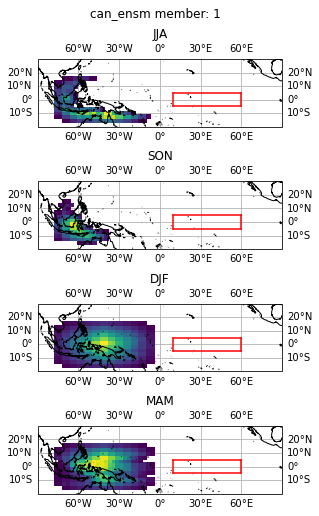

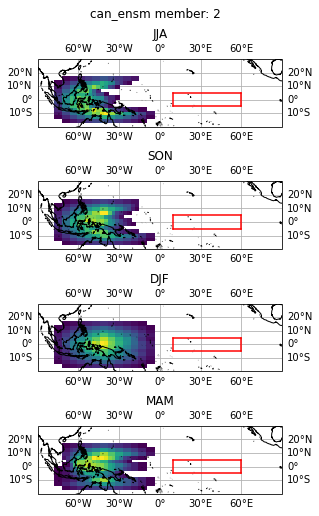

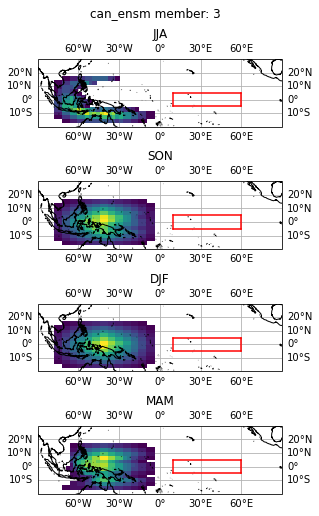

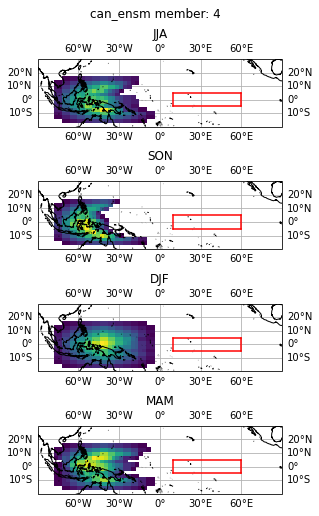

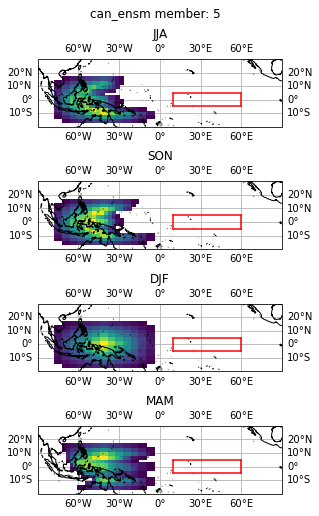

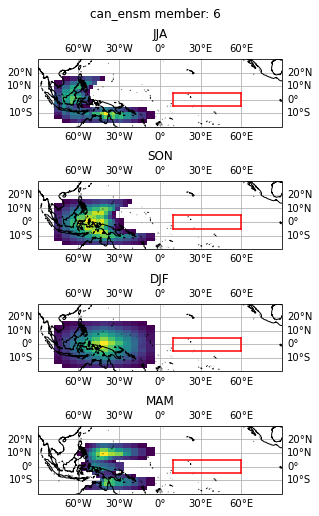

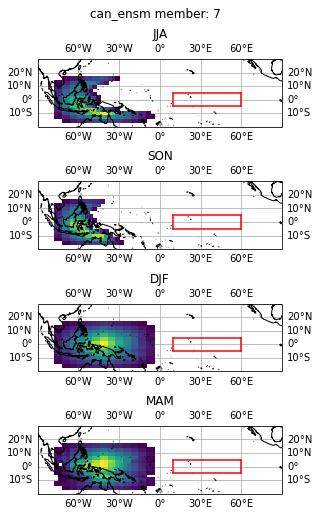

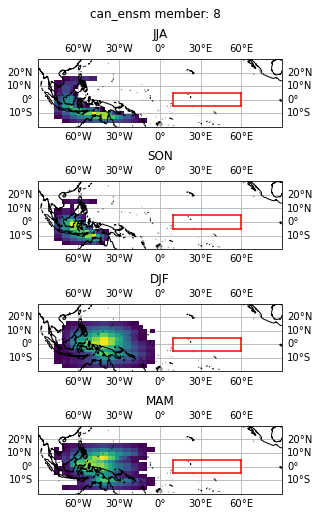

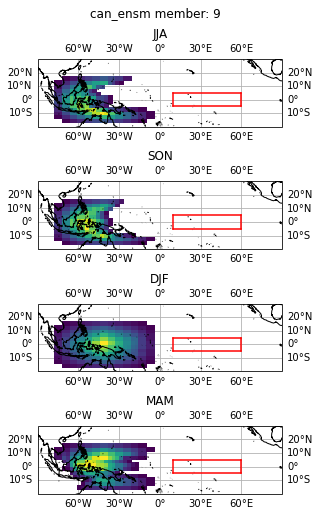

In [7]:
#########################  ---------------  INITIALIZERS  ----------------  ######################### 

## PICK ONE OF THE FOLLOWING BOXES TO USE, COMMENT OUT THE OTHER ONE

#########################################################
daatype = 'can_ensm'                                    #
first_ensm_inloop, end_ensm_inloop =  1,10   #1, 2       #
#first_ensm_inloop, end_ensm_inloop = 1, 51 #maximum    #
sea100_daa = sea100_can                                 #
#########################################################

# #########################################################
# daatype = 'mpi_ensm'                                    #
# first_ensm_inloop, end_ensm_inloop = 1, 2               #
# #first_ensm_inloop, end_ensm_inloop = 1, 101  #maximum  #
# sea100_daa = sea100_mpi                                 #
# #########################################################

## OTHER SETTINGS 
num_of_pcs=3
## *if I get to the point of NH or EXTROPICAL, PUT THAT HERE*

## caclulate the number of 
num_ensms = end_ensm_inloop-first_ensm_inloop
## this stores the precip PCA vs nino34 SST corr and explained variance for each ensemble member and PC number
cc_nn34 = np.zeros((4, num_ensms, num_of_pcs)) ## 4, for the 4 seasons
ev_nn34 = np.zeros((4, num_ensms, num_of_pcs))

## this intializer was used for a single NDI box. In this code, we are testing many NDI boxes.
# cc_epmc = np.zeros((4, num_ensms, num_of_pcs))
# ev_epmc = np.zeros((4, num_ensms, num_of_pcs))

#####################################################################################################

##### BEGIN LOOPING ENSEMBLE MEMBERS
for n_e in range(first_ensm_inloop, end_ensm_inloop):

    ##### ---- OPEN ts (SST) FILE for single ensemble member
    list_of_files_ts = []
    filename_ts = alexas_functions.get_filename(daatype, 'ts', exp='historical', r=n_e)
    list_of_files_ts.append(filename_ts)
    
    if daatype=='mpi_ensm' or daatype=='cmip6':
        list_of_files_ts.append( alexas_functions.get_filename(daatype, 'ts', exp='rcp85',r=n_e) )
        
    ts_mon = xr.open_mfdataset(list_of_files_ts)
    ts_mon.close()
    
    ## apply mask to make ts only contain 100% ocean points
    ts_mon_sea100 = ts_mon.copy()
    ts_mon_sea100['ts'].values = ts_mon_sea100['ts'].values*sea100_daa

    ## sample the monthly sst to seasonal means
    ts_seas = ts_mon_sea100.resample(time="Q-NOV").mean() 
    ts_seas = ts_seas.isel(time=(slice(2,-3))) ## lines it up to JJA, SON, DJF, MAM

    ## extract nino3.4 region, calculating sst over reagion in return form function
    nn34_seas = alexas_functions.extract_region(ts_seas, nn34[0], nn34[1], nn34[2], nn34[3], mean='yes')


    ################################################################
    ##### ----  OPEN PRECIP FILE(s) for single ensemble member
    list_of_files_pr = []
    filename_pr = alexas_functions.get_filename(daatype, 'pr', exp='historical', r=n_e)
    list_of_files_pr.append(filename_pr)
    
    if daatype=='mpi_ensm' or daatype=='cmip6':
        list_of_files_pr.append( alexas_functions.get_filename(daatype, 'pr', exp='rcp85', r=n_e) )    

    pr_mon = xr.open_mfdataset(list_of_files_pr)
    pr_mon.close()
    
    print(filename_pr)
    
    ## save lat and lon size data 
    latsize=len(pr_mon.lat.values)
    lonsize=len(pr_mon.lon.values)
    timesize_mon = len(pr_mon.time.values)
    #print(latsize, lonsize, timesize_mon)


    ## sample the seasonal pr data to seasonal means
    pr_seas = pr_mon.resample(time="Q-NOV").mean()
    pr_seas = pr_seas.isel(time=(slice(2,-3)))


    ## multiply the precip by the latitudinal cosine weights
    lat_cos_weights = np.cos(np.deg2rad(pr_seas.lat.values)).reshape((latsize,1)) 
    pr_seas.pr.values = pr_seas.pr.values *lat_cos_weights

    #### --- INITIALIZE PCA DATA LISTS
    
    ## TS:  PC time series for all seasons 
    pr_PCTS_glob = []

    ## G: Grid spatial map of PCA for all seasons 
    pr_PCG_glob = []

    ## expl: explained variance for all seasons 
    pr_expl_var_glob = []
    
    ##### BEGIN LOOPING EACH SEASON
    for s in range(4):

        seas=season_nums[s]
        pr_1seas = pr_seas.sel(time=pr_seas['time.month'] ==  seas)
        pr_glob = pr_1seas

        PCG_glob, PCTS_glob, expl_var_glob = alexas_functions.get_PC_components(pr_glob, num_of_pcs, opt='all')
        pr_PCG_glob.append(PCG_glob)
        pr_PCTS_glob.append(PCTS_glob)
        pr_expl_var_glob.append(expl_var_glob)


        nn34_1seas = nn34_seas.sel( time = nn34_seas['time.month'] == seas )['ts']
        #epmc_1seas = epmc_seas.sel( time = epmc_seas['time.month'] == seas )['ts']
        
        ##### pc loop
        for pci in range(num_of_pcs):

            cc_nn34[s, n_e-first_ensm_inloop, pci], ev_nn34[s, n_e-first_ensm_inloop, pci] = alexas_functions.cc_ev(nn34_1seas, pr_PCTS_glob[s][pci])
            #cc_epmc[s, n_e-1, pci], ev_epmc[s, n_e-1, pci] = cc_ev(epmc_1seas, pr_PCTS_glob[s][pci])
    
    
    
    cenlats, cenlons = alexas_functions.search_box(ts_seas, nn34_seas, [nn34], pr_PCTS_glob, ev_nn34,  latincr_rng = range(2,18,2), lonincr_rng = range(10,52,4), lonslice=slice(90,190))        
    
    
    hits_seas = [np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)]
    lats_un_seas = [np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)]
    lons_un_seas = [np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)]
    
    for s in range(4):
        hits_seas[s], lats_un_seas[s], lons_un_seas[s] = alexas_functions.calc_hits_num(cenlats[s], cenlons[s])
        hits_seas[s][hits_seas[s]==0.]=np.nan
        
        

    four_panel_heatmap_plot()


In [6]:

def four_panel_heatmap_plot():
    center = 180
    proj = ccrs.PlateCarree(central_longitude=center)
    #fig = plt.figure()
    fig, ax = plt.subplots(4,1, figsize=(5, 8), subplot_kw={'projection': proj})
    
    for s in range(4):
        ax[s].coastlines()


        # ax.set_extent([minlon, maxlon, -45, 45], ccrs.PlateCarree())
        ax[s].gridlines(draw_labels=True, crs=proj, zorder=0)
        ax[s].set_ylim([-20,30])
        ax[s].set_xlim([-90,90]) #ax.set_xlim([-180,180])

        #ax.scatter(hits_lons-cl, hits_lats, alpha=0.01)
        pc = ax[s].pcolormesh(lons_un_seas[s]-center, lats_un_seas[s], hits_seas[s])
        #ax.scatter(215-center, 0, color='red', s=3)

        ax[s].plot([nn34[2]-center, nn34[3]-center], [nn34[0],nn34[0]], color='red')
        ax[s].plot([nn34[2]-center, nn34[3]-center], [nn34[1],nn34[1]], color='red')

        ax[s].plot([nn34[2]-center, nn34[2]-center], [nn34[0], nn34[1]], color='red')
        ax[s].plot([nn34[3]-center, nn34[3]-center], [nn34[0], nn34[1]], color='red')

        ax[s].set_title(f'{seas_names2[s]}')
    
        
#     plt.subplots_adjust(left=0,
#                     bottom=0, 
#                     right=1, 
#                     top=1.15)
    plt.subplots_adjust(hspace = 0.8)
                    #wspace=0.4, 
                    #hspace=0.4)
    #fig.suptitle(f'heat map of box centroids for an MC box | {daatype} member: {first_ensm_inloop}', y=0.96)
    #plt.show()
    fig.suptitle(f'{daatype} member: {n_e}', y=0.97)
    
    plt.savefig(f'mcbox_hits_{daatype}_{n_e}.png', dpi=300)


#four_panel_heatmap_plot()